In [ ]:
print("Hello World.")

Hello World.


In [122]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#!pip install openml
from sklearn.datasets import fetch_openml#40996

data = fetch_openml(data_id=40996, as_frame=False, cache=True)
print(type(data))
print(data.keys())

<class 'sklearn.utils._bunch.Bunch'>
dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [123]:
# Extract features and target
X = data.data
y = data.target

# Convert to numpy arrays if they aren't already
X = np.array(X.astype(np.float32))
y = np.array(y.astype(np.float32))

# Combine features and target for shuffling
combined_data = np.column_stack((y, X))

# Shuffle the data
np.random.shuffle(combined_data)

# Split into dev and training sets
dev_size = 1000
data_dev = combined_data[:dev_size].T
Y_dev = data_dev[0]
X_dev = data_dev[1:]

data_train = combined_data[dev_size:].T
Y_train = data_train[0]
X_train = data_train[1:]

Y_dev = Y_dev.astype(np.int32)
Y_train = Y_train.astype(np.int32)

# Normalize the data
X_dev = X_dev / 255.
X_train = X_train / 255.

# Get the shapes
m_dev, n_dev = X_dev.shape
m_train, n_train = X_train.shape

print(f"Development set shape: {X_dev.shape}")
print(f"Training set shape: {X_train.shape}")

Development set shape: (784, 1000)
Training set shape: (784, 69000)


In [124]:
Y_train

array([6, 8, 7, ..., 6, 2, 6], dtype=int32)

In [128]:
def init_params(layer_sizes):
    parameters = {}
    for i in range(1, len(layer_sizes)):
        parameters[f'W{i}'] = np.random.randn(layer_sizes[i], layer_sizes[i-1]).astype(np.float32) * np.sqrt(2. / layer_sizes[i-1])
        parameters[f'b{i}'] = np.zeros((layer_sizes[i], 1)).astype(np.float32)
        parameters[f'gamma{i}'] = np.ones((layer_sizes[i], 1)).astype(np.float32)
        parameters[f'beta{i}'] = np.zeros((layer_sizes[i], 1)).astype(np.float32)
    return parameters

def leaky_relu(Z, alpha=0.01):
    return np.maximum(alpha * Z, Z)

def leaky_relu_derivative(Z, alpha=0.01):
    dZ = np.ones_like(Z)
    dZ[Z < 0] = alpha
    return dZ

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def batch_norm(Z, gamma, beta, epsilon=1e-8):
    mean = np.mean(Z, axis=1, keepdims=True)
    var = np.var(Z, axis=1, keepdims=True)
    Z_norm = (Z - mean) / np.sqrt(var + epsilon)
    return gamma * Z_norm + beta, mean, var

def forward_propagation(X, parameters):
    cache = {'A0': X}
    L = len(parameters) // 4  # Now we have 4 parameters per layer (W, b, gamma, beta)
    for i in range(1, L):
        Z = parameters[f'W{i}'].dot(cache[f'A{i-1}']) + parameters[f'b{i}']
        Z_norm, mean, var = batch_norm(Z, parameters[f'gamma{i}'], parameters[f'beta{i}'])
        cache[f'Z_norm{i}'], cache[f'mean{i}'], cache[f'var{i}'] = Z_norm, mean, var
        cache[f'A{i}'] = leaky_relu(Z_norm)

    # Output layer (without batch norm)
    Z = parameters[f'W{L}'].dot(cache[f'A{L-1}']) + parameters[f'b{L}']
    cache[f'A{L}'] = softmax(Z)
    return cache

def backward_propagation(Y, cache, parameters):
    gradients = {}
    m = Y.shape[1]
    L = len(parameters) // 4

    dZ = cache[f'A{L}'] - Y
    for i in reversed(range(1, L + 1)):
        gradients[f'dW{i}'] = 1/m * dZ.dot(cache[f'A{i-1}'].T)
        gradients[f'db{i}'] = 1/m * np.sum(dZ, axis=1, keepdims=True)

        if i > 1:
            dA = parameters[f'W{i}'].T.dot(dZ)
            dZ_norm = dA * leaky_relu_derivative(cache[f'Z_norm{i-1}'])

            # Batch norm backward pass
            dgamma = np.sum(dZ_norm * cache[f'Z_norm{i-1}'], axis=1, keepdims=True)
            dbeta = np.sum(dZ_norm, axis=1, keepdims=True)

            gradients[f'dgamma{i-1}'] = dgamma
            gradients[f'dbeta{i-1}'] = dbeta

            dZ = parameters[f'gamma{i-1}'] * dZ_norm

    return gradients

def clip_gradients(gradients, max_value=5):
    for key in gradients:
        np.clip(gradients[key], -max_value, max_value, out=gradients[key])
    return gradients

def update_parameters(parameters, gradients, learning_rate):
    L = len(parameters) // 4
    for i in range(1, L + 1):
        parameters[f'W{i}'] -= learning_rate * gradients[f'dW{i}']
        parameters[f'b{i}'] -= learning_rate * gradients[f'db{i}']
        if i < L:
            parameters[f'gamma{i}'] -= learning_rate * gradients[f'dgamma{i}']
            parameters[f'beta{i}'] -= learning_rate * gradients[f'dbeta{i}']
    return parameters

In [129]:
def get_accuracy(predictions, Y):
    return np.mean(predictions == Y)

def one_hot_encode(Y, num_classes):
    return np.eye(num_classes)[Y.reshape(-1)].T

def train_model(X, Y, layer_sizes, learning_rate, num_iterations):
    if X.shape[0] != layer_sizes[0]:
        X = X.T
    if Y.ndim == 1 or Y.shape[0] == 1:
        Y = one_hot_encode(Y, layer_sizes[-1])

    parameters = init_params(layer_sizes)

    for i in range(num_iterations):
        cache = forward_propagation(X, parameters)
        gradients = backward_propagation(Y, cache, parameters)
        gradients = clip_gradients(gradients)
        parameters = update_parameters(parameters, gradients, learning_rate)

        if i % 25 == 0:
            predictions = np.argmax(cache[f'A{len(layer_sizes)-1}'], axis=0)
            accuracy = get_accuracy(predictions, np.argmax(Y, axis=0))
            print(f"Iteration {i}: Accuracy = {accuracy}")

    return parameters

In [130]:
# Specify the number of hidden layers and their sizes
input_size = 784  # For MNIST
HIDDEN_LAYERS = [10]  # Example: 3 hidden layers with 16, 32, and 16 nodes respectively; note this worked poorly
output_size = 10  # For 10 digits
layer_sizes = [input_size] + HIDDEN_LAYERS + [output_size]


trained_parameters = train_model(X_train, Y_train, layer_sizes, learning_rate=0.10, num_iterations=501)

Iteration 0: Accuracy = 0.0638695652173913
Iteration 25: Accuracy = 0.5199130434782608
Iteration 50: Accuracy = 0.6239710144927536
Iteration 75: Accuracy = 0.6939565217391305
Iteration 100: Accuracy = 0.7019565217391305
Iteration 125: Accuracy = 0.6591014492753623
Iteration 150: Accuracy = 0.6358115942028986
Iteration 175: Accuracy = 0.596231884057971
Iteration 200: Accuracy = 0.6663768115942029
Iteration 225: Accuracy = 0.6765652173913044
Iteration 250: Accuracy = 0.6712173913043479
Iteration 275: Accuracy = 0.6213768115942029
Iteration 300: Accuracy = 0.6208985507246377
Iteration 325: Accuracy = 0.6546376811594203
Iteration 350: Accuracy = 0.6093188405797102
Iteration 375: Accuracy = 0.6614927536231884
Iteration 400: Accuracy = 0.6942608695652174
Iteration 425: Accuracy = 0.6603043478260869
Iteration 450: Accuracy = 0.6819710144927537
Iteration 475: Accuracy = 0.7023478260869566
Iteration 500: Accuracy = 0.6654492753623188


In [131]:
def make_predictions(X, parameters):
    cache = forward_propagation(X, parameters)
    predictions = np.argmax(cache[f'A{len(layer_sizes)-1}'], axis=0)
    return predictions

def test_prediction(index, X_train, Y_train, parameters):
    current_image = X_train[:, index, None]
    prediction = make_predictions(current_image, parameters)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    # Reshape and denormalize the image
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [0]
Label:  6


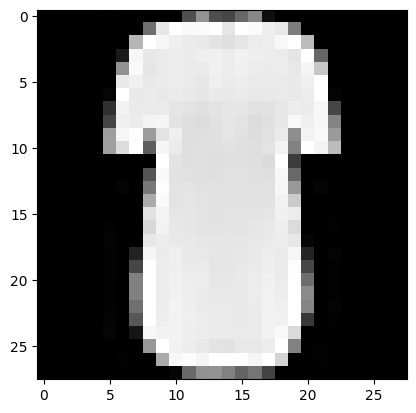

Prediction:  [0]
Label:  8


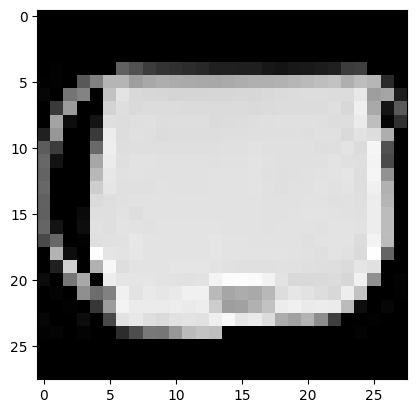

Prediction:  [0]
Label:  7


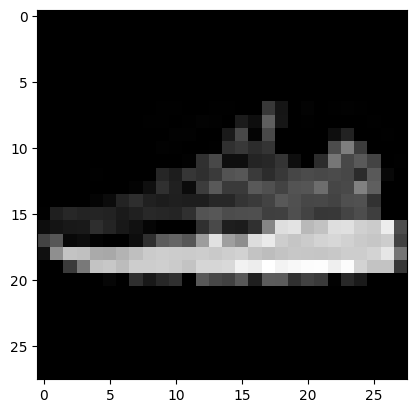

Prediction:  [0]
Label:  2


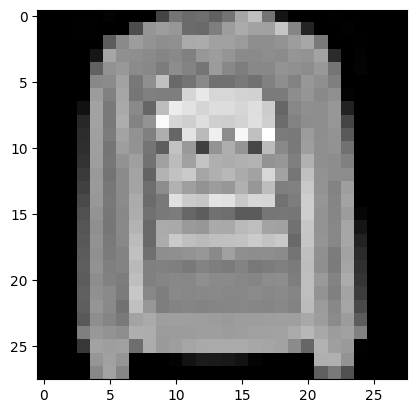

Prediction:  [0]
Label:  6


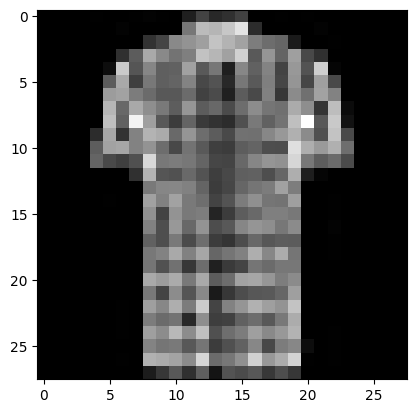

Prediction:  [0]
Label:  5


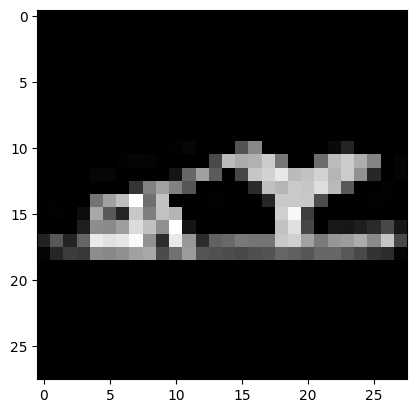

In [132]:
test_prediction(0, X_train, Y_train, trained_parameters)
test_prediction(1, X_train, Y_train, trained_parameters)
test_prediction(2, X_train, Y_train, trained_parameters)
test_prediction(10, X_train, Y_train, trained_parameters)
test_prediction(11, X_train, Y_train, trained_parameters)
test_prediction(12, X_train, Y_train, trained_parameters)

In [133]:
def get_accuracy(predictions, Y):
    return np.mean(predictions == Y)

def evaluate_dev_set(X_dev, Y_dev, parameters):
    dev_predictions = make_predictions(X_dev, parameters)
    accuracy = get_accuracy(dev_predictions, Y_dev)
    return accuracy


dev_accuracy = evaluate_dev_set(X_dev, Y_dev, trained_parameters)
print(f"Development set accuracy: {dev_accuracy:.4f}")

Development set accuracy: 0.6240


In [134]:
# Specify the number of hidden layers and their sizes
input_size = 784  # For MNIST
HIDDEN_LAYERS = [10, 10]  # Example: 3 hidden layers with 16, 32, and 16 nodes respectively; note this worked poorly
output_size = 10  # For 10 digits
layer_sizes = [input_size] + HIDDEN_LAYERS + [output_size]


trained_parameters_2 = train_model(X_train, Y_train, layer_sizes, learning_rate=0.10, num_iterations=501)

Iteration 0: Accuracy = 0.13455072463768117
Iteration 25: Accuracy = 0.2614492753623188
Iteration 50: Accuracy = 0.34356521739130436
Iteration 75: Accuracy = 0.5073333333333333
Iteration 100: Accuracy = 0.576231884057971
Iteration 125: Accuracy = 0.5748840579710145
Iteration 150: Accuracy = 0.5177826086956522
Iteration 175: Accuracy = 0.6186666666666667
Iteration 200: Accuracy = 0.5990144927536232
Iteration 225: Accuracy = 0.695304347826087
Iteration 250: Accuracy = 0.7156231884057971
Iteration 275: Accuracy = 0.7354347826086957
Iteration 300: Accuracy = 0.7253188405797102
Iteration 325: Accuracy = 0.7411884057971014
Iteration 350: Accuracy = 0.6349130434782608
Iteration 375: Accuracy = 0.41284057971014493
Iteration 400: Accuracy = 0.4038840579710145
Iteration 425: Accuracy = 0.3932898550724638
Iteration 450: Accuracy = 0.3736231884057971
Iteration 475: Accuracy = 0.25069565217391304
Iteration 500: Accuracy = 0.4192173913043478


Prediction:  [6]
Label:  6


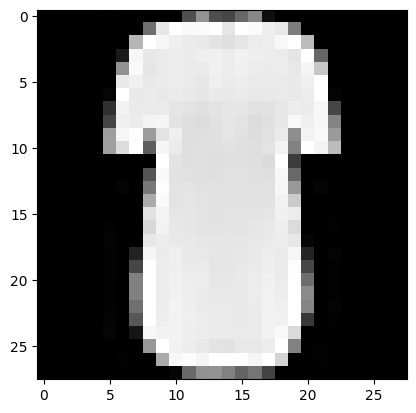

Prediction:  [6]
Label:  8


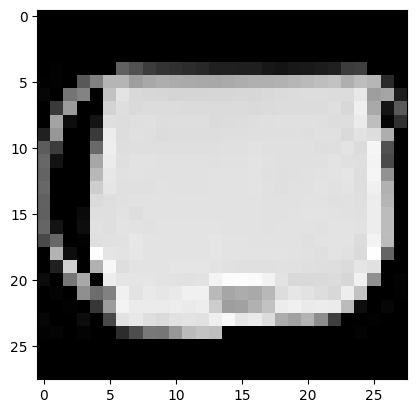

Prediction:  [6]
Label:  7


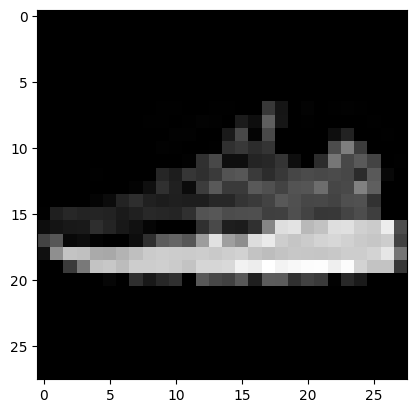

Prediction:  [6]
Label:  2


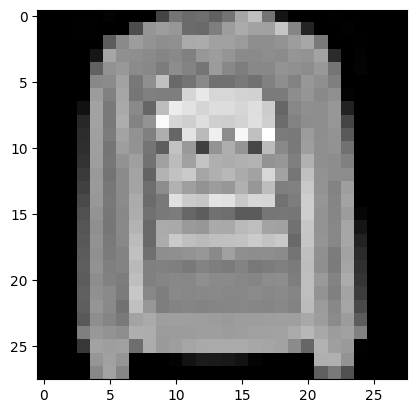

Prediction:  [6]
Label:  6


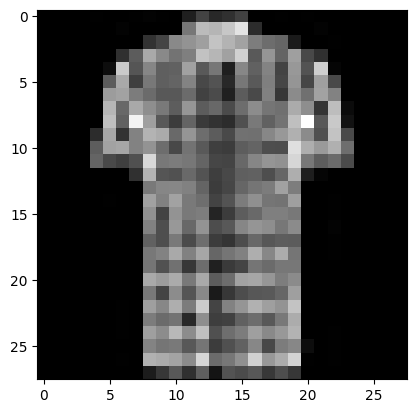

Prediction:  [6]
Label:  5


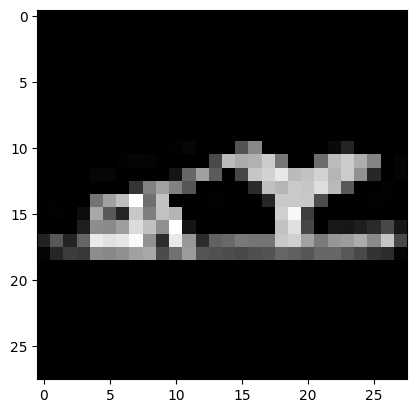

In [135]:
test_prediction(0, X_train, Y_train, trained_parameters_2)
test_prediction(1, X_train, Y_train, trained_parameters_2)
test_prediction(2, X_train, Y_train, trained_parameters_2)
test_prediction(10, X_train, Y_train, trained_parameters_2)
test_prediction(11, X_train, Y_train, trained_parameters_2)
test_prediction(12, X_train, Y_train, trained_parameters_2)

In [136]:
dev_accuracy = evaluate_dev_set(X_dev, Y_dev, trained_parameters_2)
print(f"Development set accuracy: {dev_accuracy:.4f}")

Development set accuracy: 0.4280


In [140]:
# Specify the number of hidden layers and their sizes
input_size = 784  # For MNIST
HIDDEN_LAYERS = [16, 32, 16]  # Example: 3 hidden layers with 16, 32, and 16 nodes respectively
output_size = 10  # For 10 digits
layer_sizes = [input_size] + HIDDEN_LAYERS + [output_size]


trained_parameters_3 = train_model(X_train, Y_train, layer_sizes, learning_rate=0.003, num_iterations=1001)

Iteration 0: Accuracy = 0.0758695652173913
Iteration 25: Accuracy = 0.15359420289855072
Iteration 50: Accuracy = 0.22257971014492753
Iteration 75: Accuracy = 0.2729710144927536
Iteration 100: Accuracy = 0.3428985507246377
Iteration 125: Accuracy = 0.41144927536231884
Iteration 150: Accuracy = 0.4583333333333333
Iteration 175: Accuracy = 0.49585507246376814
Iteration 200: Accuracy = 0.5292028985507247
Iteration 225: Accuracy = 0.5610579710144927
Iteration 250: Accuracy = 0.5952898550724638
Iteration 275: Accuracy = 0.635927536231884
Iteration 300: Accuracy = 0.6902898550724638
Iteration 325: Accuracy = 0.7225942028985507
Iteration 350: Accuracy = 0.7441449275362318
Iteration 375: Accuracy = 0.760536231884058
Iteration 400: Accuracy = 0.7697536231884058
Iteration 425: Accuracy = 0.7793478260869565
Iteration 450: Accuracy = 0.7879130434782609
Iteration 475: Accuracy = 0.7943478260869565
Iteration 500: Accuracy = 0.8023333333333333
Iteration 525: Accuracy = 0.8070434782608695
Iteration 550

Prediction:  [0]
Label:  6


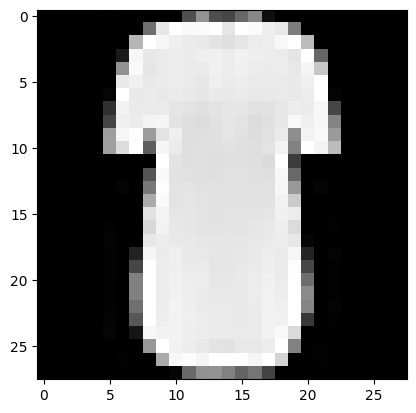

Prediction:  [0]
Label:  8


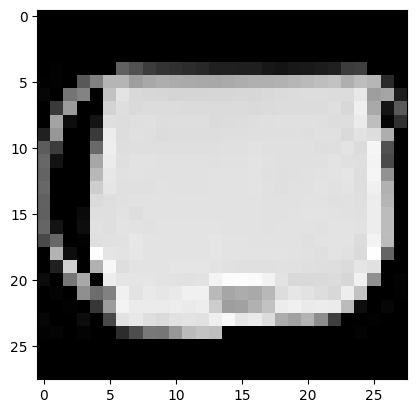

Prediction:  [0]
Label:  7


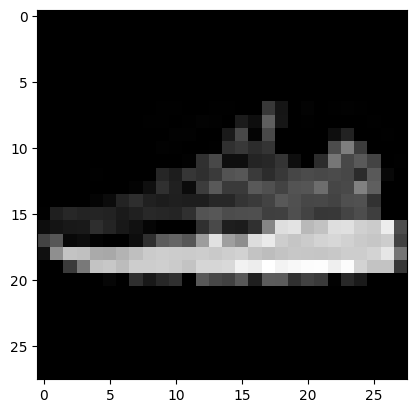

Prediction:  [0]
Label:  2


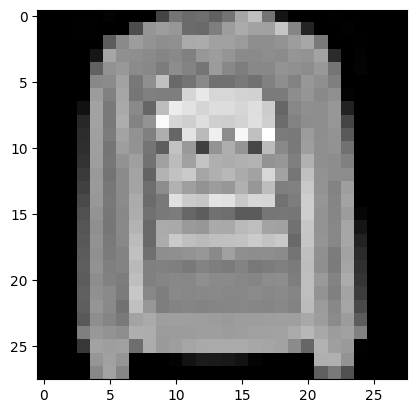

Prediction:  [0]
Label:  6


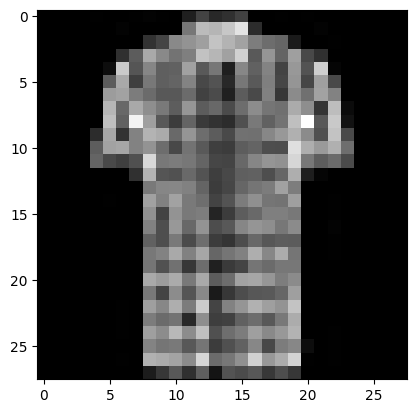

Prediction:  [0]
Label:  5


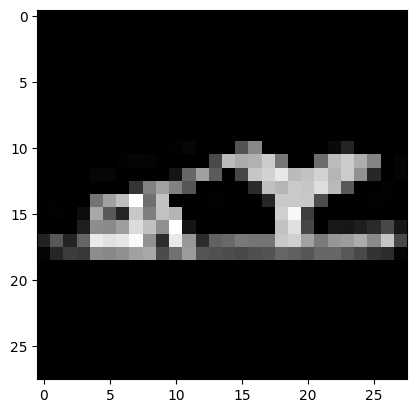

In [141]:
test_prediction(0, X_train, Y_train, trained_parameters_3)
test_prediction(1, X_train, Y_train, trained_parameters_3)
test_prediction(2, X_train, Y_train, trained_parameters_3)
test_prediction(10, X_train, Y_train, trained_parameters_3)
test_prediction(11, X_train, Y_train, trained_parameters_3)
test_prediction(12, X_train, Y_train, trained_parameters_3)

In [142]:
dev_accuracy = evaluate_dev_set(X_dev, Y_dev, trained_parameters_3)
print(f"Development set accuracy: {dev_accuracy:.4f}")

Development set accuracy: 0.7570
